<a href="https://colab.research.google.com/github/buildwithdemis/machinelearning/blob/main/ML_ch_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We saw how cost functions evaluate how well models perform by using data. The optimizer is the final piece of the puzzle.

The optimizer's role is to alter the model in a way that improves its performance. It does this alteration by inspecting the model outputs and cost and suggesting new parameters for the model.

**Gradient descent**

The most common optimization algorithm today is gradient descent. Several variants of this algorithm exist, but they all use the same core concepts.

Gradient descent uses calculus to estimate how changing each parameter changes the cost. For example, increasing a parameter might be predicted to reduce the cost.

**Exercise: Gradient descent**

Previously, we identified trends in winter temperatures by fitting a linear regression model to weather data. Here, we'll repeat this process by focusing on the optimizer. Specifically, we'll work with batch gradient descent and explore how changing the learning rate can alter its behavior.

**Loading data and preparing our model**

Let's load up our weather data from Seattle, filter to January temperatures, and make slight adjustments so that the dates are mathematically interpretable.

--2025-06-02 17:14:57--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/seattleWeather_1948-2017.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 762017 (744K) [text/plain]
Saving to: ‘seattleWeather_1948-2017.csv’

seattleWeather_1948 100%[===================>] 744.16K  --.-KB/s    in 0.04s   

2025-06-02 17:14:57 (16.3 MB/s) - ‘seattleWeather_1948-2017.csv’ saved [762017/762017]



<ipython-input-1-c85e998273c2>:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


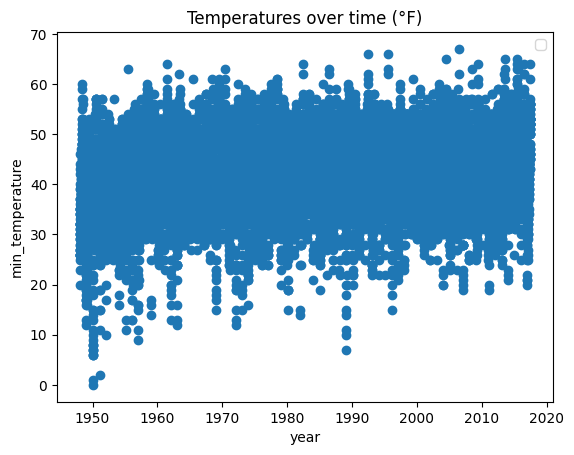

In [1]:
from datetime import datetime
import pandas
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

!pip install statsmodels
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/seattleWeather_1948-2017.csv

# Load a file that contains weather data for Seattle
data = pandas.read_csv('seattleWeather_1948-2017.csv', parse_dates=['date'])

# Remove all dates after July 1 because we have to to plant onions before summer begins
data = data[[d.month < 7 for d in data.date]].copy()


# Convert the dates into numbers so we can use them in our models
# We make a year column that can contain fractions. For example,
# 1948.5 is halfway through the year 1948
data["year"] = [(d.year + d.timetuple().tm_yday / 365.25) for d in data.date]

# Let's take a quick look at our data
plt.scatter(data["year"], data["min_temperature"])

# add labels and legend
plt.xlabel("year")
plt.ylabel("min_temperature")
plt.title("Temperatures over time (°F)")
plt.legend()

**Fitting a model automatically**

Let's fit a line to this data well by using an existing library.

In [2]:
import statsmodels.formula.api as smf

# Perform linear regression to fit a line to our data
# NB OLS uses the sum or mean of squared differences as a cost function,
# which we're familiar with from our last exercise
model = smf.ols(formula = "min_temperature ~ year", data = data).fit()

# Print the model
intercept = model.params[0]
slope = model.params[1]

print(f"The model is: y = {slope:0.3f} * X + {intercept:0.3f}")

The model is: y = 0.063 * X + -83.073


<ipython-input-2-7eaf091ff749>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]
<ipython-input-2-7eaf091ff749>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]


Y is temperature (°F).

X is year.

-83 is a model parameter that acts as the line offset.

0.063 is a model parameter that defines the line slope (in °F per year).

So, this little equation states that the model estimates temperature by multiplying the year by 0.063 and then subtracting 83.

How did the library calculate these values? Let's go through the process.

Model selection

The first step is always selecting a model. Let's reuse the model that we used in previous exercises.

In [3]:
class MyModel:

    def __init__(self):
        '''
        Creates a new MyModel
        '''
        # Straight lines described by two parameters:
        # The slope is the angle of the line
        self.slope = 0
        # The intercept moves the line up or down
        self.intercept = 0

    def predict(self, date):
        '''
        Estimates the temperature from the date
        '''
        return date * self.slope + self.intercept

    def get_summary(self):
        '''
        Returns a string that summarises the model
        '''
        return f"y = {self.slope} * x + {self.intercept}"

print("Model class ready")

Model class ready


**Implementing gradient descent**

To implement gradient descent, we need a method that can calculate the preceding curve's gradient.

In [4]:
import numpy as np

x = data.year
temperature_true = data.min_temperature

# Here, we set:
#   x to a range of potential model intercepts
#   y to a range of potential model slopes
#   z as the cost for that combination of model parameters

# Choose a range of intercepts and slopes values
intercepts = np.linspace(-100,-70,10)
slopes = np.linspace(0.060,0.07,10)


# Set a cost function. This will be the mean of squared differences
def cost_function(temperature_estimate):
    """
    Calculates cost for a given temperature estimate
    Our cost function is the mean of squared differences (a.k.a. mean squared error)
    """
    # Note that with NumPy to square each value, we use **
    return np.mean((temperature_true - temperature_estimate) ** 2)

def predict_and_calc_cost(intercept, slope):
    '''
    Uses the model to make a prediction, then calculates the cost
    '''

    # Predict temperature by using these model parameters
    temperature_estimate = x * slope + intercept

    # Calculate cost
    return cost_function(temperature_estimate)

def calculate_gradient(temperature_estimate):
    """
    This calculates the gradient for a linear regession
    by using the Mean Squared Error cost function
    """

    # The partial derivatives of MSE are as follows
    # You don't need to be able to do this just yet, but
    # it's important to note that these give you the two gradients
    # that we need to train our model
    error = temperature_estimate - temperature_true
    grad_intercept = np.mean(error) * 2
    grad_slope = (x * error).mean() * 2

    return grad_intercept, grad_slope

print("Function is ready!")

Function is ready!


Now all we need is a starting guess and a loop that updates this guess with each iteration.

In [5]:
def gradient_descent(learning_rate, number_of_iterations):
    """
    Performs gradient descent for a one-variable function.

    learning_rate: Larger numbers follow the gradient more aggressively
    number_of_iterations: The maximum number of iterations to perform
    """

    # Our starting guess is y = 0 * x - 83
    # We're going to start with the correct intercept so that
    # only the line's slope is estimated. This is just to keep
    # things simple for this exercise
    model = MyModel()
    model.intercept = -83
    model.slope = 0

    for i in range(number_of_iterations):
        # Calculate the predicted values
        predicted_temperature = model.predict(x)

        # == OPTIMIZER ===
        # Calculate the gradient
        _, grad_slope = calculate_gradient(predicted_temperature)
        # Update the estimation of the line
        model.slope -= learning_rate * grad_slope

        # Print the current estimation and cost every 100 iterations
        if( i % 100 == 0):
            estimate = model.predict(x)
            cost = cost_function(estimate)
            print("Next estimate:", model.get_summary(), f"Cost: {cost}")

    # Print the final model
    print(f"Final estimate:", model.get_summary())

# Run gradient descent
gradient_descent(learning_rate=1E-9, number_of_iterations=1000)

Next estimate: y = 0.0004946403321335815 * x + -83 Cost: 15374.064817888926
Next estimate: y = 0.034564263954523125 * x + -83 Cost: 3218.050332426434
Next estimate: y = 0.050035120236006536 * x + -83 Cost: 711.4491469584532
Next estimate: y = 0.057060363506525755 * x + -83 Cost: 194.58159053167708
Next estimate: y = 0.060250493523378544 * x + -83 Cost: 88.00218235322349
Next estimate: y = 0.06169911660055105 * x + -83 Cost: 66.02523660294695
Next estimate: y = 0.06235692954504888 * x + -83 Cost: 61.4935343467107
Next estimate: y = 0.0626556393176375 * x + -83 Cost: 60.559085785362484
Next estimate: y = 0.06279128202425543 * x + -83 Cost: 60.36640010911254
Next estimate: y = 0.06285287674109104 * x + -83 Cost: 60.32666783130979
Final estimate: y = 0.06288066221361607 * x + -83


Our model found the correct answer, but it took a number of steps. Looking at the printout, we can see how it progressively stepped toward the correct solution.

Now, what happens if we make the learning rate faster? This means taking larger steps.

In [6]:
gradient_descent(learning_rate=1E-8, number_of_iterations=200)

Next estimate: y = 0.004946403321335815 * x + -83 Cost: 13267.277888290606
Next estimate: y = 0.06288803098785394 * x + -83 Cost: 60.317363492453254
Final estimate: y = 0.0629041077135948 * x + -83


Our model appears to have found the solution faster. If we increase the rate even more, however, things don't go so well:

In [7]:
gradient_descent(learning_rate=5E-7, number_of_iterations=500)

Next estimate: y = 0.24732016606679072 * x + -83 Cost: 133774.64171440934
Next estimate: y = 9.500952345613634e+45 * x + -83 Cost: 3.549071667291563e+98
Next estimate: y = 4.8948068107652476e+92 * x + -83 Cost: 9.420015144175701e+191
Next estimate: y = 2.52176127646564e+139 * x + -83 Cost: 2.500278766819551e+285
Next estimate: y = 1.2991891572708264e+186 * x + -83 Cost: inf
Final estimate: y = -2.2830799448010082e+232 * x + -83


Notice how the cost is getting worse each time.

This is because the steps that the model was taking were too large. Although it stepped toward the correct solution, it stepped too far and actually got worse with each attempt.

For each model, there's an ideal learning rate. It requires experimentation.

**Fitting multiple variables simultaneously**

We've just fit one variable here to keep things simple. Expanding this to fit multiple variables requires only a few small code changes:

We need to update more than one variable in the gradient descent loop.

We need to do some preprocessing of the data, which we alluded to in an earlier exercise. We'll cover how and why in later learning material.

**Summary**

Well done! In this unit, we:

Watched gradient descent in action.

Saw how changing the learning rate can improve a model's training speed.

Learned that changing the learning rate can also result in unstable models.

**brainstorming Questions**

**What is the difference between supervised learning and unsupervised learning?**

Supervised learning trains a model by comparing estimations to correct answers. The cost function for unsupervised learning doesn't need correct answers.

**What is the role of the cost function in supervised learning?**

To calculate the cost by comparing estimations to correct answers.

**How does gradient descent know how to update parameters?**

it uses calculus to estimate the slope of the cost function.

**Why are many cost functions available?**

Different cost functions can arrive at different answers, and what's best depends on the goal.

**Why is learning rate important?**


*  It speeds up or slows down training.
*  If the learning rate is too large or too small, it can prevent a model from being trained optimally.



